Loading tokenizers and model...
Test dataset size: 2857
Running batch predictions with batch size 64...
Processing 0/2857...
Processing 640/2857...
Processing 1280/2857...
Processing 1920/2857...
Processing 2560/2857...

ENGLISH TO KHMER EVALUATION RESULTS
Word-Level Accuracy:      0.3318
Character-Level Accuracy: 0.7373
Average Character F1:     0.8012
Average CER:              0.2873

Detailed results saved to: /home/kanade3010/Documents/khmer_romanization/results/eng2khm/eng2khm_evaluation.csv


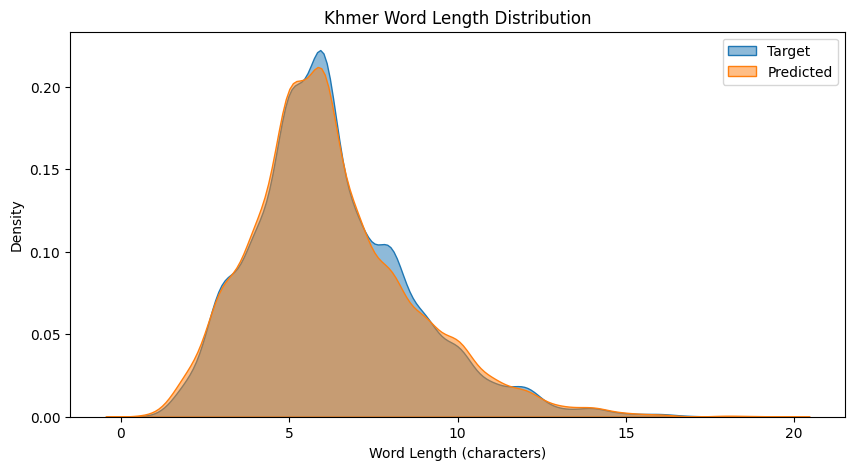

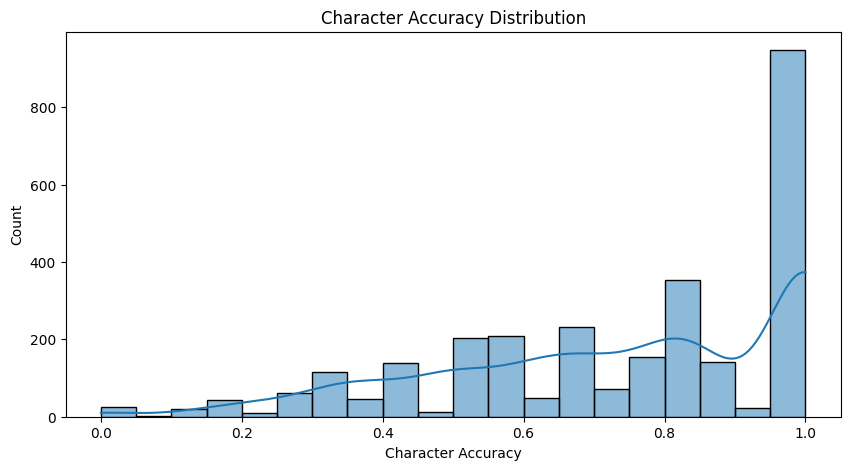


Evaluation complete!


In [ ]:
# Evaluation For English to Khmer Model (Notebook 01)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import unicodedata
import re
import editdistance

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

# -----------------------------
# 0. Configuration
# -----------------------------
EMBED_DIM = 32
LSTM_UNITS = 64
BATCH_SIZE = 64  # Batch size for faster evaluation

BASE_DIR = os.path.abspath('..')
DATA_PATH = os.path.join(BASE_DIR, 'data/raw/eng_khm_data.csv')
MODEL_PATH = os.path.join(BASE_DIR, 'models/khmer_transliterator.keras')
ASSETS_PATH = os.path.join(BASE_DIR, 'data/processed/khmer_transliteration_assets.pkl')
RESULTS_PATH = os.path.join(BASE_DIR, 'results/eng2khm/')
os.makedirs(RESULTS_PATH, exist_ok=True)

# -----------------------------
# 1. Load Assets
# -----------------------------
print("Loading tokenizers and model...")
with open(ASSETS_PATH, 'rb') as f:
    assets = pickle.load(f)

eng_tokenizer = assets['eng_tokenizer']
khm_tokenizer = assets['khm_tokenizer']
max_eng_len = assets['max_eng_len']
max_khm_len = assets['max_khm_len']

# Load model
model = load_model(MODEL_PATH)

# -----------------------------
# 2. Build Inference Models
# -----------------------------
# Encoder model
encoder_inputs = model.input[0]
encoder_outputs, state_h, state_c = model.get_layer("encoder_lstm").output
encoder_model = Model(encoder_inputs, [state_h, state_c])

# Decoder model
from tensorflow.keras.layers import Input
decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(LSTM_UNITS,))
decoder_state_input_c = Input(shape=(LSTM_UNITS,))
decoder_states = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = model.get_layer("decoder_lstm")(
    model.get_layer("decoder_embedding")(decoder_inputs),
    initial_state=decoder_states
)
decoder_outputs = model.get_layer("decoder_dense")(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states,
    [decoder_outputs, state_h, state_c]
)

# -----------------------------
# 3. Load Test Dataset
# -----------------------------
df = pd.read_csv(DATA_PATH)
dataset = []

for _, row in df.iterrows():
    normalized_eng = re.sub(r"[^a-z]", "", row['eng'].lower())
    normalized_khm = re.sub(r"[^\u1780-\u17FF]", "", row['khm'])
    normalized_khm = unicodedata.normalize('NFC', normalized_khm)
    dataset.append((normalized_eng, normalized_khm))

# Use 10% for testing
test_size = int(len(dataset) * 0.1)
test_dataset = dataset[-test_size:]  # Use last 10%

print(f"Test dataset size: {len(test_dataset)}")

# -----------------------------
# 4. Batch Inference Function
# -----------------------------
def transliterate_batch(texts):
    """Batch English to Khmer transliteration for faster processing"""
    # Preprocess batch
    processed_texts = []
    for text in texts:
        text = str(text).strip()
        text = re.sub(r"[^a-z]", "", text.lower())
        processed_texts.append(text if text else " ")
    
    # Encode all texts
    seqs = eng_tokenizer.texts_to_sequences(processed_texts)
    encoder_inputs = pad_sequences(seqs, maxlen=max_eng_len, padding='post')
    
    # Get initial states for all samples
    states_h, states_c = encoder_model.predict(encoder_inputs, verbose=0)
    
    # Initialize decoder input for batch
    batch_size = len(texts)
    target_seq = np.zeros((batch_size, 1))
    target_seq[:, 0] = khm_tokenizer.word_index['\t']
    
    # Track decoding for each sample
    decoded_results = [[] for _ in range(batch_size)]
    active_samples = list(range(batch_size))
    
    # Decode step by step
    for step in range(max_khm_len + 1):
        if not active_samples:
            break
            
        # Predict for active samples
        active_target_seq = target_seq[active_samples]
        active_states_h = states_h[active_samples]
        active_states_c = states_c[active_samples]
        
        output_tokens, new_h, new_c = decoder_model.predict(
            [active_target_seq, active_states_h, active_states_c], 
            verbose=0
        )
        
        # Process predictions
        newly_finished = []
        for i, sample_idx in enumerate(active_samples):
            char_index = np.argmax(output_tokens[i, -1, :])
            char = khm_tokenizer.index_word.get(char_index, '')
            
            if char == '\n':
                newly_finished.append(sample_idx)
            else:
                decoded_results[sample_idx].append(char)
                target_seq[sample_idx, 0] = char_index
                states_h[sample_idx] = new_h[i]
                states_c[sample_idx] = new_c[i]
        
        # Remove finished samples
        active_samples = [idx for idx in active_samples if idx not in newly_finished]
    
    # Join results and normalize
    return [unicodedata.normalize('NFC', ''.join(chars)) for chars in decoded_results]


# -----------------------------
# 5. Run Batch Predictions
# -----------------------------
print(f"Running batch predictions with batch size {BATCH_SIZE}...")
results_data = []

for batch_start in range(0, len(test_dataset), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(test_dataset))
    batch = test_dataset[batch_start:batch_end]
    
    if batch_start % (BATCH_SIZE * 10) == 0:
        print(f"Processing {batch_start}/{len(test_dataset)}...")
    
    # Extract inputs and targets
    eng_inputs = [item[0] for item in batch]
    khm_targets = [item[1] for item in batch]
    
    # Batch prediction
    khm_preds = transliterate_batch(eng_inputs)
    
    # Calculate metrics for each sample in batch
    for eng, khm_target, khm_pred in zip(eng_inputs, khm_targets, khm_preds):
        # Calculate metrics
        is_exact_match = 1 if khm_pred == khm_target else 0
        
        # Character-level accuracy using edit distance
        dist = editdistance.eval(khm_pred, khm_target)
        max_len = max(len(khm_pred), len(khm_target))
        char_acc = 1 - (dist / max_len) if max_len > 0 else 1.0
        
        # CER
        cer = dist / len(khm_target) if len(khm_target) > 0 else 0.0
        
        # Character-level F1
        pred_chars = list(khm_pred)
        target_chars = list(khm_target)
        
        common_chars = 0
        if len(pred_chars) > 0 and len(target_chars) > 0:
            pred_counter = pd.Series(pred_chars).value_counts()
            target_counter = pd.Series(target_chars).value_counts()
            
            for char, count in pred_counter.items():
                if char in target_counter:
                    common_chars += min(count, target_counter[char])
        
        precision = common_chars / len(pred_chars) if len(pred_chars) > 0 else 0
        recall = common_chars / len(target_chars) if len(target_chars) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results_data.append({
            'Input_English': eng,
            'Target_Khmer': khm_target,
            'Predicted_Khmer': khm_pred,
            'Word_Acc': is_exact_match,
            'Char_Acc': char_acc,
            'F1': f1,
            'CER': cer
        })

# -----------------------------
# 6. Compute Aggregate Metrics
# -----------------------------
results_df = pd.DataFrame(results_data)

avg_word_acc = results_df['Word_Acc'].mean()
avg_char_acc = results_df['Char_Acc'].mean()
avg_f1 = results_df['F1'].mean()
avg_cer = results_df['CER'].mean()

print("\n" + "="*50)
print("ENGLISH TO KHMER EVALUATION RESULTS")
print("="*50)
print(f"Word-Level Accuracy:      {avg_word_acc:.4f}")
print(f"Character-Level Accuracy: {avg_char_acc:.4f}")
print(f"Average Character F1:     {avg_f1:.4f}")
print(f"Average CER:              {avg_cer:.4f}")
print("="*50)

# -----------------------------
# 7. Save Results
# -----------------------------
csv_path = os.path.join(RESULTS_PATH, 'eng2khm_evaluation.csv')
results_df.to_csv(csv_path, index=False)
print(f"\nDetailed results saved to: {csv_path}")

# -----------------------------
# 8. Visualizations
# -----------------------------
# Word length distribution
plt.figure(figsize=(10, 5))
target_lengths = [len(word) for word in results_df['Target_Khmer']]
pred_lengths = [len(word) for word in results_df['Predicted_Khmer']]

sns.kdeplot(target_lengths, fill=True, label='Target', alpha=0.5)
sns.kdeplot(pred_lengths, fill=True, label='Predicted', alpha=0.5)
plt.title("Khmer Word Length Distribution")
plt.xlabel("Word Length (characters)")
plt.ylabel("Density")
plt.legend()
plt.savefig(os.path.join(RESULTS_PATH, "word_length_density.png"))
plt.show()

# Accuracy distribution
plt.figure(figsize=(10, 5))
sns.histplot(results_df['Char_Acc'], bins=20, kde=True)
plt.title("Character Accuracy Distribution")
plt.xlabel("Character Accuracy")
plt.ylabel("Count")
plt.savefig(os.path.join(RESULTS_PATH, "accuracy_distribution.png"))
plt.show()

print("\nEvaluation complete!")

Loading tokenizers and model...
Test dataset size: 2857
Running batch predictions with batch size 64...
Processing 0/2857...
Processing 640/2857...
Processing 1280/2857...
Processing 1920/2857...
Processing 2560/2857...

KHMER TO ENGLISH EVALUATION RESULTS
Word-Level Accuracy:      0.3280
Character-Level Accuracy: 0.7970
Average Character F1:     0.8675
Average CER:              0.2226

Detailed results saved to: /home/kanade3010/Documents/khmer_romanization/results/khm2eng/khm2eng_evaluation.csv


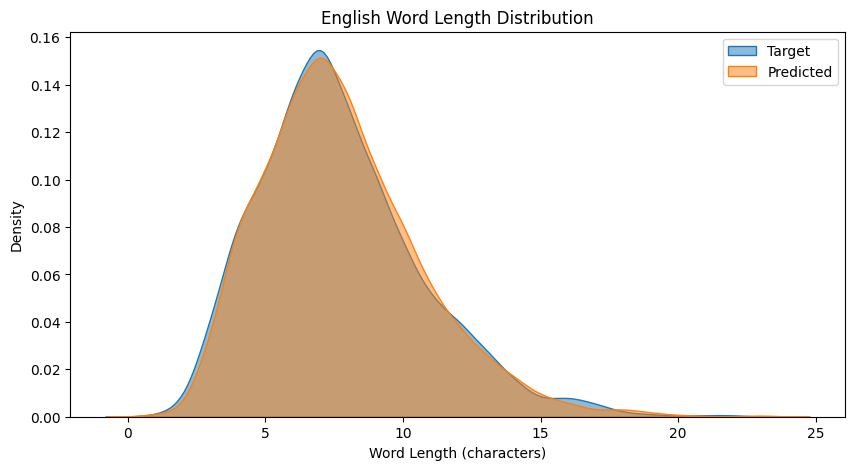

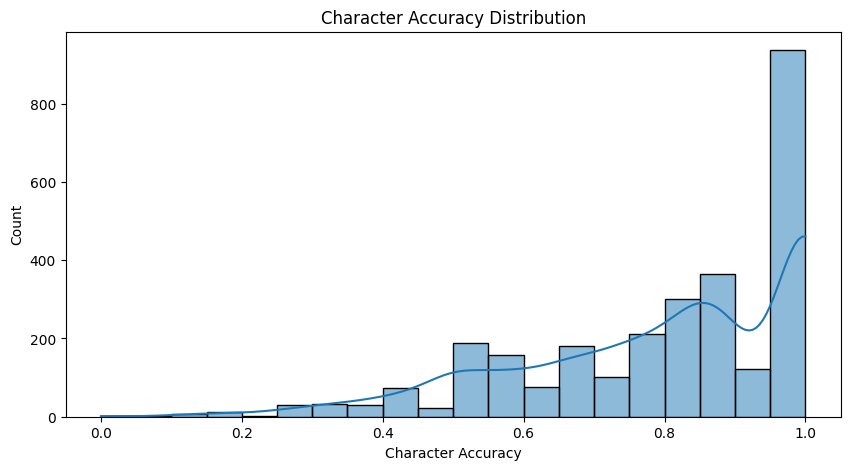


SAMPLE PREDICTIONS (First 10)
 Input_Khmer    Target_English Predicted_English  Word_Acc
       ក្រយៅ            kroyov            kroyov         1
        រ៉ែៗ              reae              reae         1
      ព្យាធិ           pyeathi            pyeath         0
        បំពម            bampom            bampom         1
      ប្រយូរ            brayur            broyor         0
      ប្រសប់            brosob            brosob         1
       ឥណ្ឌា             india             indea         0
      កុមារី           komarey           komeari         0
        ធ្មា             thmea             thmea         1
បញ្ជាប់ពាក្យ banhcheabapeakyar    banhcheapopeak         0

Evaluation complete!


In [5]:
# Evaluation For Khmer to English Model (Notebook 02)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import unicodedata
import re
import editdistance

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

# -----------------------------
# 0. Configuration
# -----------------------------
EMBED_DIM = 32
LSTM_UNITS = 64
BATCH_SIZE = 64  # Batch size for faster evaluation

BASE_DIR = os.path.abspath('..')
DATA_PATH = os.path.join(BASE_DIR, 'data/raw/eng_khm_data.csv')
MODEL_PATH = os.path.join(BASE_DIR, 'models/english_romanizer.keras')
ASSETS_PATH = os.path.join(BASE_DIR, 'data/processed/english_romanization_assets.pkl')
RESULTS_PATH = os.path.join(BASE_DIR, 'results/khm2eng/')
os.makedirs(RESULTS_PATH, exist_ok=True)

# -----------------------------
# 1. Load Assets
# -----------------------------
print("Loading tokenizers and model...")
with open(ASSETS_PATH, 'rb') as f:
    assets = pickle.load(f)

khm_tokenizer = assets['khm_tokenizer']
eng_tokenizer = assets['eng_tokenizer']
max_khm_len = assets['max_khm_len']
max_eng_len = assets['max_eng_len']

# Load model
model = load_model(MODEL_PATH)

# -----------------------------
# 2. Build Inference Models
# -----------------------------
# Encoder model
encoder_inputs = model.input[0]
encoder_outputs, state_h, state_c = model.get_layer("encoder_lstm").output
encoder_model = Model(encoder_inputs, [state_h, state_c])

# Decoder model
from tensorflow.keras.layers import Input
decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(LSTM_UNITS,))
decoder_state_input_c = Input(shape=(LSTM_UNITS,))
decoder_states = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = model.get_layer("decoder_lstm")(
    model.get_layer("decoder_embedding")(decoder_inputs),
    initial_state=decoder_states
)
decoder_outputs = model.get_layer("decoder_dense")(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states,
    [decoder_outputs, state_h, state_c]
)

# -----------------------------
# 3. Load Test Dataset
# -----------------------------
df = pd.read_csv(DATA_PATH)
dataset = []

for _, row in df.iterrows():
    normalized_khm = re.sub(r"[^\u1780-\u17FF]", "", row['khm'])
    normalized_khm = unicodedata.normalize('NFC', normalized_khm)
    normalized_eng = re.sub(r"[^a-z]", "", row['eng'].lower())
    dataset.append((normalized_khm, normalized_eng))

# Use 10% for testing
test_size = int(len(dataset) * 0.1)
test_dataset = dataset[-test_size:]  # Use last 10%

print(f"Test dataset size: {len(test_dataset)}")

# -----------------------------
# 4. Batch Inference Function
# -----------------------------
def romanize_batch(texts):
    """Batch Khmer to English romanization for faster processing"""
    # Preprocess batch
    processed_texts = []
    for text in texts:
        text = str(text).strip()
        text = re.sub(r"[^\u1780-\u17FF]", "", text)
        text = unicodedata.normalize('NFC', text)
        processed_texts.append(text if text else " ")
    
    # Encode all texts
    seqs = khm_tokenizer.texts_to_sequences(processed_texts)
    encoder_inputs = pad_sequences(seqs, maxlen=max_khm_len, padding='post')
    
    # Get initial states for all samples
    states_h, states_c = encoder_model.predict(encoder_inputs, verbose=0)
    
    # Initialize decoder input for batch
    batch_size = len(texts)
    target_seq = np.zeros((batch_size, 1))
    target_seq[:, 0] = eng_tokenizer.word_index['\t']
    
    # Track decoding for each sample
    decoded_results = [[] for _ in range(batch_size)]
    active_samples = list(range(batch_size))
    
    # Decode step by step
    for step in range(max_eng_len + 1):
        if not active_samples:
            break
            
        # Predict for active samples
        active_target_seq = target_seq[active_samples]
        active_states_h = states_h[active_samples]
        active_states_c = states_c[active_samples]
        
        output_tokens, new_h, new_c = decoder_model.predict(
            [active_target_seq, active_states_h, active_states_c], 
            verbose=0
        )
        
        # Process predictions
        newly_finished = []
        for i, sample_idx in enumerate(active_samples):
            char_index = np.argmax(output_tokens[i, -1, :])
            char = eng_tokenizer.index_word.get(char_index, '')
            
            if char == '\n':
                newly_finished.append(sample_idx)
            else:
                decoded_results[sample_idx].append(char)
                target_seq[sample_idx, 0] = char_index
                states_h[sample_idx] = new_h[i]
                states_c[sample_idx] = new_c[i]
        
        # Remove finished samples
        active_samples = [idx for idx in active_samples if idx not in newly_finished]
    
    # Join results
    return [''.join(chars) for chars in decoded_results]


# -----------------------------
# 5. Run Batch Predictions
# -----------------------------
print(f"Running batch predictions with batch size {BATCH_SIZE}...")
results_data = []

for batch_start in range(0, len(test_dataset), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(test_dataset))
    batch = test_dataset[batch_start:batch_end]
    
    if batch_start % (BATCH_SIZE * 10) == 0:
        print(f"Processing {batch_start}/{len(test_dataset)}...")
    
    # Extract inputs and targets
    khm_inputs = [item[0] for item in batch]
    eng_targets = [item[1] for item in batch]
    
    # Batch prediction
    eng_preds = romanize_batch(khm_inputs)
    
    # Calculate metrics for each sample in batch
    for khm, eng_target, eng_pred in zip(khm_inputs, eng_targets, eng_preds):
        # Calculate metrics
        is_exact_match = 1 if eng_pred == eng_target else 0
        
        # Character-level accuracy using edit distance
        dist = editdistance.eval(eng_pred, eng_target)
        max_len = max(len(eng_pred), len(eng_target))
        char_acc = 1 - (dist / max_len) if max_len > 0 else 1.0
        
        # CER
        cer = dist / len(eng_target) if len(eng_target) > 0 else 0.0
        
        # Character-level F1
        pred_chars = list(eng_pred)
        target_chars = list(eng_target)
        
        common_chars = 0
        if len(pred_chars) > 0 and len(target_chars) > 0:
            pred_counter = pd.Series(pred_chars).value_counts()
            target_counter = pd.Series(target_chars).value_counts()
            
            for char, count in pred_counter.items():
                if char in target_counter:
                    common_chars += min(count, target_counter[char])
        
        precision = common_chars / len(pred_chars) if len(pred_chars) > 0 else 0
        recall = common_chars / len(target_chars) if len(target_chars) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results_data.append({
            'Input_Khmer': khm,
            'Target_English': eng_target,
            'Predicted_English': eng_pred,
            'Word_Acc': is_exact_match,
            'Char_Acc': char_acc,
            'F1': f1,
            'CER': cer
        })

# -----------------------------
# 6. Compute Aggregate Metrics
# -----------------------------
results_df = pd.DataFrame(results_data)

avg_word_acc = results_df['Word_Acc'].mean()
avg_char_acc = results_df['Char_Acc'].mean()
avg_f1 = results_df['F1'].mean()
avg_cer = results_df['CER'].mean()

print("\n" + "="*50)
print("KHMER TO ENGLISH EVALUATION RESULTS")
print("="*50)
print(f"Word-Level Accuracy:      {avg_word_acc:.4f}")
print(f"Character-Level Accuracy: {avg_char_acc:.4f}")
print(f"Average Character F1:     {avg_f1:.4f}")
print(f"Average CER:              {avg_cer:.4f}")
print("="*50)

# -----------------------------
# 7. Save Results
# -----------------------------
csv_path = os.path.join(RESULTS_PATH, 'khm2eng_evaluation.csv')
results_df.to_csv(csv_path, index=False)
print(f"\nDetailed results saved to: {csv_path}")

# -----------------------------
# 8. Visualizations
# -----------------------------
# Word length distribution
plt.figure(figsize=(10, 5))
target_lengths = [len(word) for word in results_df['Target_English']]
pred_lengths = [len(word) for word in results_df['Predicted_English']]

sns.kdeplot(target_lengths, fill=True, label='Target', alpha=0.5)
sns.kdeplot(pred_lengths, fill=True, label='Predicted', alpha=0.5)
plt.title("English Word Length Distribution")
plt.xlabel("Word Length (characters)")
plt.ylabel("Density")
plt.legend()
plt.savefig(os.path.join(RESULTS_PATH, "word_length_density.png"))
plt.show()

# Accuracy distribution
plt.figure(figsize=(10, 5))
sns.histplot(results_df['Char_Acc'], bins=20, kde=True)
plt.title("Character Accuracy Distribution")
plt.xlabel("Character Accuracy")
plt.ylabel("Count")
plt.savefig(os.path.join(RESULTS_PATH, "accuracy_distribution.png"))
plt.show()

# Sample predictions table
print("\n" + "="*50)
print("SAMPLE PREDICTIONS (First 10)")
print("="*50)
print(results_df[['Input_Khmer', 'Target_English', 'Predicted_English', 'Word_Acc']].head(10).to_string(index=False))

print("\nEvaluation complete!")